# Experiment - Data Preparation Techniques
* StelllarAlgo Data Science
* Ryan Kazmerik, Grant Donst, Peter Morrison
* Mar 03, 2023

This experiment aims to test the performance and explainability of the LightGBM algorithm vs. the Logistic Regression algorithm for use in the Event Propensity model.

In [1]:
import pandas as pd

from data_sci_toolkit.aws_tools import redshift_tools
from pycaret.classification import *

/opt/miniconda3/envs/stellar/lib/python3.8/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


### Let's grab a training dataset for our model comparison:

In [2]:
df = redshift_tools.get_event_propensity_training_dataset(
    cluster= "prod-app",
    database= "stlrflames",
    lkupclientid= 36,
    start_year= 2010,
    end_year= 2022
)

df.shape

Authorized as AROASQ4JELIXYLYV6P4UV:rkazmerik@stellaralgo.com


(880070, 14)

In [6]:
#df.to_parquet("./data/Algo-Experiment-Training.parquet")

: 

In [2]:
df = pd.read_parquet("./data/Algo-Experiment-Training.parquet")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 863762 entries, 0 to 863761
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   daysout              863762 non-null  object        
 1   mindaysout           863762 non-null  int64         
 2   maxdaysout           863762 non-null  int64         
 3   dimcustomermasterid  863762 non-null  int64         
 4   eventdate            863762 non-null  datetime64[ns]
 5   inmarket             724182 non-null  object        
 6   distancetovenue      724182 non-null  float64       
 7   tenure               863762 non-null  object        
 8   did_purchase         863762 non-null  int64         
 9   events_purchased     863762 non-null  object        
 10  frequency_opponent   863762 non-null  object        
 11  frequency_eventday   863762 non-null  object        
 12  frequency_eventtime  863762 non-null  object        
 13  count_merchown

In [3]:
setup(
    data= df, 
    target="did_purchase", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=[
        "count_merchowned",
        "daysout",
        "dimcustomermasterid",
        "eventdate",
        "inmarket",
        "mindaysout",
        "maxdaysout"
    ],
    silent=True,
    verbose=False,
    numeric_features=[
        "distancetovenue",
        "events_purchased",
        "frequency_eventday",
        "frequency_opponent",
        "frequency_eventtime",
        "tenure"
    ]
);

In [23]:
model_matrix = compare_models(
    fold= 10,
    include= ["lightgbm","lr"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.6760,0.7488,0.6958,0.6696,0.6824,0.3520,0.3523,2.0950
lr,Logistic Regression,0.6128,0.6626,0.5799,0.6210,0.5998,0.2256,0.2261,1.1180


### The LightGBM model appears to outperform the LR model in every performance metric. Let's have a look at the feature importances to see what the most significant factors are according to each model:

In [4]:
lgbm = create_model(estimator="lightgbm")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6842,0.7596,0.7101,0.6748,0.6920,0.3684,0.3689
1,0.6838,0.7563,0.7106,0.6742,0.6919,0.3676,0.3682
2,0.6831,0.7577,0.7089,0.6738,0.6909,0.3662,0.3667
3,0.6867,0.7596,0.7160,0.6761,0.6955,0.3734,0.3740
4,0.6845,0.7580,0.7126,0.6745,0.6930,0.3691,0.3697
5,0.6852,0.7585,0.7159,0.6743,0.6945,0.3705,0.3712
6,0.6872,0.7600,0.7171,0.6764,0.6962,0.3745,0.3752
7,0.6853,0.7570,0.7119,0.6757,0.6933,0.3707,0.3712
8,0.6869,0.7603,0.7144,0.6769,0.6951,0.3738,0.3744


In [4]:
lr = create_model(estimator="lr")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6213,0.6738,0.5987,0.6268,0.6125,0.2427,0.2429
1,0.6198,0.6731,0.5920,0.6266,0.6088,0.2396,0.2400
2,0.6228,0.6734,0.5964,0.6294,0.6125,0.2455,0.2459
3,0.6201,0.6722,0.5955,0.6261,0.6104,0.2402,0.2405
4,0.6218,0.6726,0.5993,0.6274,0.6130,0.2436,0.2439
5,0.6198,0.6726,0.5943,0.6260,0.6097,0.2396,0.2399
6,0.6208,0.6732,0.5990,0.6261,0.6122,0.2416,0.2418
7,0.6213,0.6724,0.5978,0.6270,0.6121,0.2425,0.2428
8,0.6162,0.6691,0.5948,0.6212,0.6077,0.2325,0.2327


In [ ]:
xgboost = create_model(estimator="xgboost")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6885,0.7667,0.7015,0.6839,0.6926,0.3769,0.3770
1,0.6952,0.7728,0.7056,0.6914,0.6984,0.3903,0.3904
2,0.6893,0.7668,0.7019,0.6849,0.6933,0.3786,0.3787
3,0.6890,0.7678,0.7033,0.6840,0.6935,0.3780,0.3782
4,0.6946,0.7727,0.7077,0.6899,0.6987,0.3892,0.3893
5,0.6898,0.7668,0.6994,0.6865,0.6929,0.3796,0.3797
6,0.6880,0.7652,0.6976,0.6847,0.6911,0.3760,0.3760
7,0.6910,0.7677,0.7022,0.6871,0.6946,0.3821,0.3821
8,0.6893,0.7651,0.7021,0.6848,0.6933,0.3786,0.3787


In [40]:
rf = create_model(estimator="rf")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7771,0.8513,0.7062,0.8232,0.7602,0.5543,0.5600
1,0.7789,0.8536,0.7064,0.8264,0.7617,0.5578,0.5638
2,0.7787,0.8517,0.7049,0.8273,0.7612,0.5575,0.5637
3,0.7798,0.8519,0.7029,0.8310,0.7616,0.5597,0.5665
4,0.7790,0.8524,0.7065,0.8267,0.7619,0.5581,0.5641
5,0.7823,0.8558,0.7100,0.8303,0.7654,0.5647,0.5707
6,0.7771,0.8505,0.7038,0.8250,0.7596,0.5542,0.5603
7,0.7775,0.8503,0.7051,0.8248,0.7603,0.5551,0.5611
8,0.7778,0.8504,0.7036,0.8265,0.7601,0.5557,0.5620


In [41]:
dt = create_model(estimator="dt")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7846,0.8111,0.6844,0.8563,0.7607,0.5693,0.5811
1,0.7845,0.8128,0.6832,0.8571,0.7603,0.5691,0.5812
2,0.7828,0.8111,0.6794,0.8567,0.7578,0.5656,0.5781
3,0.7837,0.8086,0.6799,0.8583,0.7587,0.5674,0.5801
4,0.7867,0.8125,0.6878,0.8577,0.7634,0.5735,0.5851
5,0.7875,0.8149,0.6854,0.8616,0.7635,0.5751,0.5875
6,0.7833,0.8107,0.6798,0.8575,0.7584,0.5666,0.5792
7,0.7838,0.8097,0.6827,0.8561,0.7596,0.5677,0.5797
8,0.7826,0.8089,0.6791,0.8566,0.7576,0.5652,0.5778


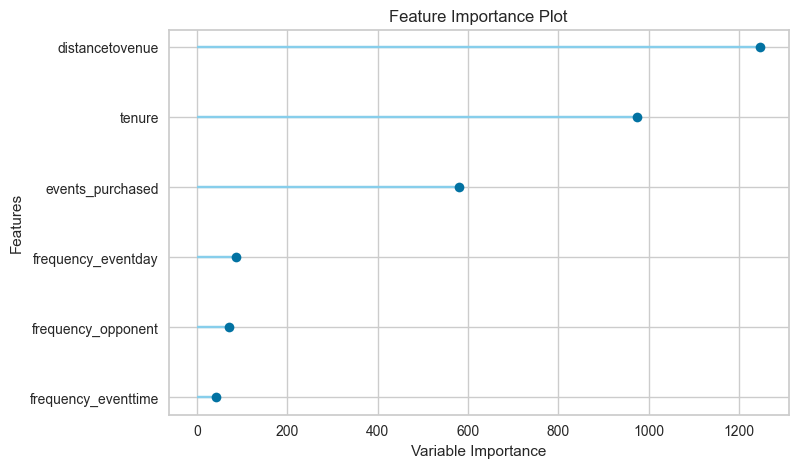

In [26]:
plot_model(lgbm, plot="feature")

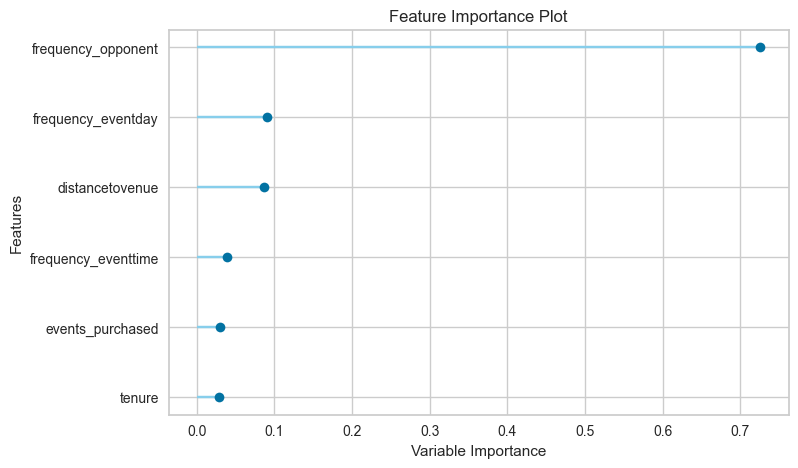

In [43]:
plot_model(xgboost, plot="feature")

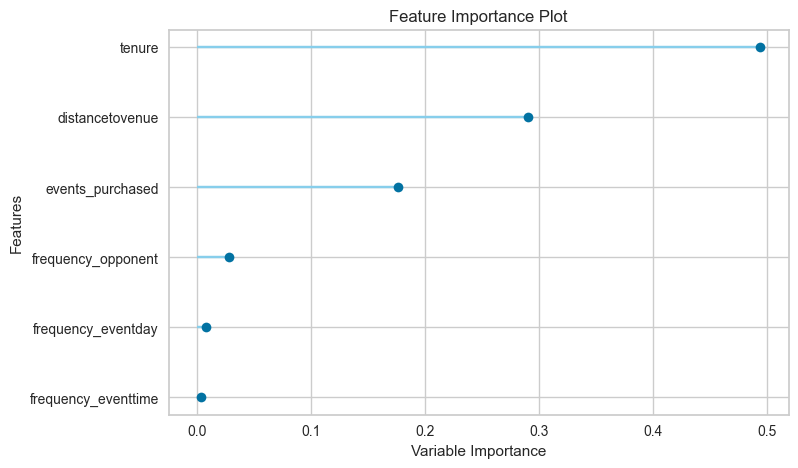

In [44]:
plot_model(rf, plot="feature")

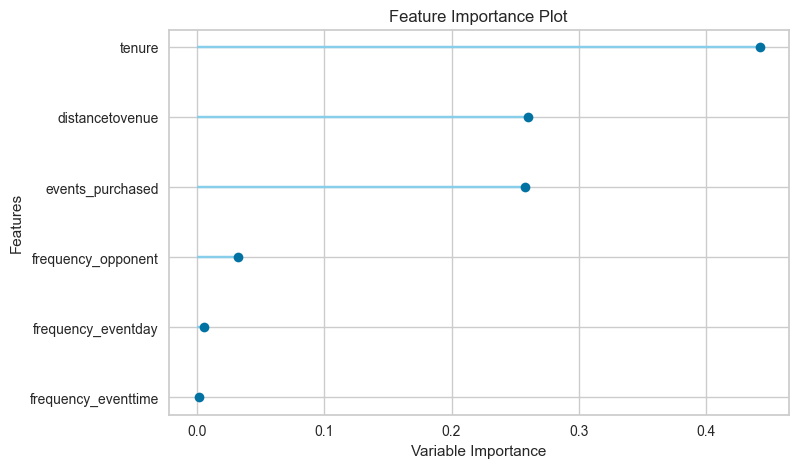

In [45]:
plot_model(dt, plot="feature")

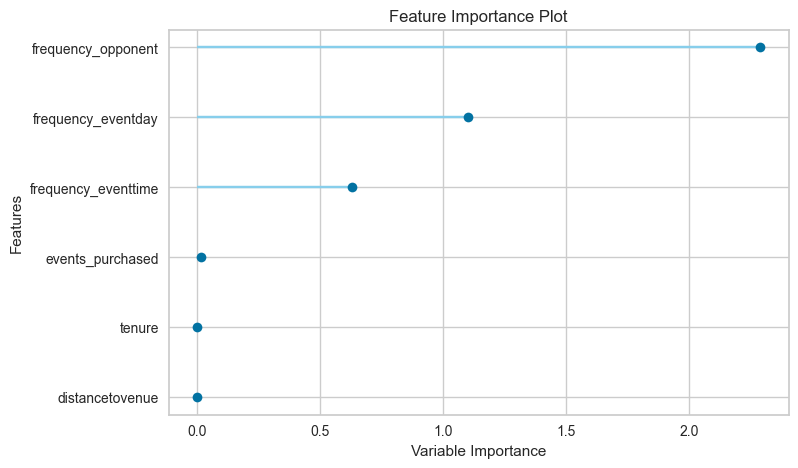

In [27]:
plot_model(lr, plot="feature")

### The LightGBM, DT & RF models rank the core features (tenure, distance, eventspurchased) as the most important factors in making a correct prediction, where as the LR model does the exact opposite and says the engineered features are what contributes to a correct prediction. The XGBoost model is a mixture of core/engineered features.

### Let's build an ensemble model of all these algorithms and see what the accuracy and feature importance looks like:

In [46]:
blend_soft = blend_models(estimator_list = [lgbm, lr, xgboost, rf, dt], method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7799,0.8548,0.7140,0.8226,0.7645,0.5599,0.5648
1,0.7807,0.8577,0.7127,0.8251,0.7648,0.5615,0.5667
2,0.7811,0.8554,0.7132,0.8256,0.7653,0.5623,0.5675
3,0.7811,0.8557,0.7103,0.8278,0.7646,0.5623,0.5681
4,0.7837,0.8578,0.7180,0.8268,0.7686,0.5674,0.5724
5,0.7828,0.8574,0.7158,0.8267,0.7673,0.5656,0.5708
6,0.7798,0.8543,0.7114,0.8245,0.7638,0.5597,0.5651
7,0.7797,0.8540,0.7118,0.8239,0.7637,0.5594,0.5646
8,0.7792,0.8534,0.7109,0.8236,0.7631,0.5584,0.5637


In [47]:
blend_hard = blend_models(estimator_list = [lgbm, lr, xgboost, rf, dt], method = 'hard')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7268,0.0000,0.7023,0.7387,0.7200,0.4536,0.4541
1,0.7297,0.0000,0.7018,0.7436,0.7221,0.4595,0.4602
2,0.7276,0.0000,0.6988,0.7417,0.7196,0.4552,0.4560
3,0.7285,0.0000,0.6963,0.7445,0.7196,0.4571,0.4581
4,0.7331,0.0000,0.7060,0.7467,0.7258,0.4662,0.4669
5,0.7278,0.0000,0.6975,0.7428,0.7195,0.4557,0.4566
6,0.7280,0.0000,0.6976,0.7430,0.7196,0.4561,0.4569
7,0.7290,0.0000,0.6989,0.7440,0.7207,0.4581,0.4589
8,0.7268,0.0000,0.6985,0.7407,0.7190,0.4536,0.4544


In [ ]:
stacked = stack_models(estimator_list = [lgbm, lr, xgboost, rf, dt])

### Ensemble and stacking models did not increase the performance beyond using a single model, and are difficult to interpret because the feature importance plot is not available.

### Let's load up the Pycaret explainability dashboard to explore these models further:

In [5]:
ds = dashboard(lr, display_format="inline")

Note: model_output='probability' is currently not supported for linear classifiers models with shap. So defaulting to model_output='logodds' If you really need probability outputs use shap='kernel' instead.
Note: shap values for shap='linear' get calculated against X_background, but paramater X_background=None, so using X instead...
Generating self.shap_explainer = shap.LinearExplainer(model, X)...
Building ExplainerDashboard..
For this type of model and model_output interactions don't work, so setting shap_interaction=False...
The explainer object has no decision_trees property. so setting decision_trees=False...
Generating layout...
Calculating shap values...
Calculating prediction probabilities...
Calculating metrics...
Calculating confusion matrices...
Calculating classification_dfs...
Calculating roc auc curves...
Calculating pr auc curves...
Calculating liftcurve_dfs...
Calculating dependencies...
Calculating permutation importances (if slow, try setting n_jobs parameter)...
Calc

### After exploring both LightGBM and LR models in the dashboard, we recommend the LR algorithm for this application because:
1. The SHAP values for each feature made logical sense.
2. We spot checked several low probability predictions, the SHAP values made logical sense.
3. We spot checked several high probability predictions, the SHAP values made logical sense.


# Done